*The XLNet model was proposed by researchers in Carnegie Mellon University, and Google AI Brain Team. XLNet is an extension of the Transformer-XL model pre-trained using an autoregressive method*

### **`Downloading and Installing libraries`**

In [ ]:
!nvidia-smi

Tue May  4 08:27:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |    931MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch

In [ ]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla K80


In [ ]:
!pip install transformers

In [ ]:
!pip install Sentencepiece

In [ ]:
!pip install demoji

In [ ]:
import transformers
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import numpy as np
from textblob import TextBlob
import pandas as pd
from nltk.tokenize import WhitespaceTokenizer
import demoji
demoji.download_codes()
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams
from nltk.tokenize import RegexpTokenizer
from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
... OK (Got response in 0.37 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
!pip install imblearn
!pip install delayed

### **`Configuring Notebook`**

In [ ]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### **`Data Loading`**

In [ ]:
columnList = ['Text', 'Label']
df = pd.read_csv("/content/DATASET_4_CLASSES.csv",index_col=0,usecols=columnList)
df.head()

,Label
Text,
"This actually broke my heart... An elderly Kisaan risking his life protesting to protect his livelihood, his heritage, his own land, his familyâ€™s future, everything heâ€™s ever known. Doesnâ€™t look like a terrorist to me. #FarmersProtest #FuckYourDemocracy #KisaanEktaZindabaad https://t.co/flRzM02saY",PF_AG
"I am a daughter of farmers, of course Iâ€™m going to roar alongside them. It is my duty to help them achieve a life of comfort as they are the reason I have received mine.âœŠðŸ½â™¥ï¸ #WeStandwithFarmers #FARMERSPROTEST",PF_AG
"â€œthe power of people is stronger than the people in powerâ€;\n\nour farmers are an epitome of resilience, strength, fearlessness and hope. \n\nà¨•à¨¿à¨¸à¨¾à¨¨ à¨®à¨œà¨¦à©‚à¨° à¨à¨•à¨¤à¨¾ à¨œà¨¿à©°à¨¦à¨¾à¨¬à¨¾à¨¦. \n\n#IStandWithFarmers \n#FarmersProtest \n#FarmersBill2020 https://t.co/Eo2YyU8pDn",PF_AG
Coming together is the beginning. Keeping together is progress. Working together is success.\n#delhidornahi #FarmerProtest https://t.co/U51MsBQgA7,PF_AG
"The farmers are more articulate and aware than most ""experts"" and anchors you see on TV channels.\nTo say that the protesting farmers don't know what is good for them is typical of the urban elite.\n#farmersprotest",PF_AG


In [ ]:
df.reset_index(inplace = True)

In [ ]:
df.iloc[15:16]

,Text,Label
15,ðŸ™ðŸ»Thank you @JustinTrudeau sir.\nAnd then we have our PM who doesnâ€™t care and is busy travelingðŸ˜¡\n#JustinTrudeau #Respect #FarmerProtest #FarmersProtest2020 #IStandWithFarmers #KisanMajdoorEktaZindabad #standwithfarmerschallange #NoFarmersNoFood @indijaswal_ https://t.co/MZ3ezVjM58,PF_AG


### **Preprocessing** 

In [ ]:
import re

def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text=  demoji.replace_with_desc(text, sep="")
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)


    # Removing Stopwords
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])

    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV} # Pos tag, used Noun, Verb, Adjective and Adverb
    pos_tagged_text = nltk.pos_tag(text.split())
    text =  " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])


    #-------------------------[4.   Emoticon Replacement with text]------------------
    tokenizer = RegexpTokenizer(r'\w+')
    words=WhitespaceTokenizer().tokenize(text.lower())
    df = pd.read_excel('/content/Emoticons_Emojis_Text.xlsx',sheet_name='Sheet2',header=0,converters={'Emoji':str,'Text':str,'Emoticons':str})
    dictOfEmoticons=df.set_index('Emoji')['Text'].to_dict()
    words=[dictOfEmoticons.get(x) if x in dictOfEmoticons.keys() else x for x in words]
    text=' '.join(words)


  
    return text

In [ ]:
df['Text'] = df['Text'].apply(clean_text)

In [ ]:
df['Text'].head(20)

0     this actually break heart... an elderly kisaan risk life protest protect livelihood heritage land family trade mark future everything trade mark ever known. doesn trade markt look like terrorist me. farmersprotest fuckyourdemocracy kisaanektazindabaad
1                                                                                            i daughter farmer course i trade markm go roar alongside them. it duty help achieve life comfort reason i receive mine. trade mark westandwithfarmers farmersprotest
2                                                                                          power people strong people power farmer epitome resilience strength fearlessness hope. register copyright copyright . istandwithfarmers farmersprotest farmersbill2020
3                                                                                                                                                      coming together beginning. keeping together progress. working together succ

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


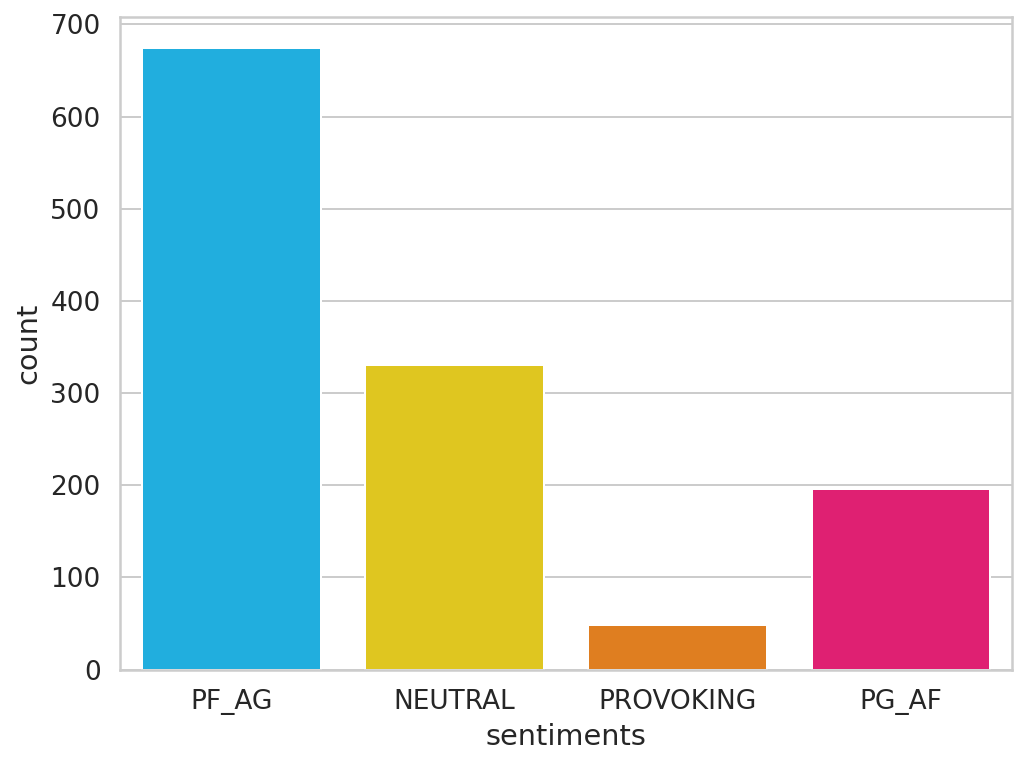

In [ ]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df.Label)
plt.xlabel('sentiments');

### **`Converting Categorical labels to numbers`**

In [ ]:
def sentiment2label(sentiment):
    if sentiment == "PF_AG":
        return 0
    elif sentiment == "NEUTRAL":
        return 1
    elif sentiment == 'PG_AF':
       return 2
    else:
       return 3

df['Label'] = df['Label'].apply(sentiment2label)

In [ ]:
# class count
class_count_0, class_count_1, class_count_2, class_count_3 = df['Label'].value_counts()

# Separate class
class_0 =  df[df['Label'] == 0]
class_1 =  df[df['Label'] == 1]
class_2 =  df[df['Label'] == 2]
class_3 =  df[df['Label'] == 3]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
print('class 2:', class_2.shape)
print('class 3:', class_3.shape)

class 0: (674, 2)
class 1: (330, 2)
class 2: (196, 2)
class 3: (48, 2)


### **Handling Class Imbalance Problem**

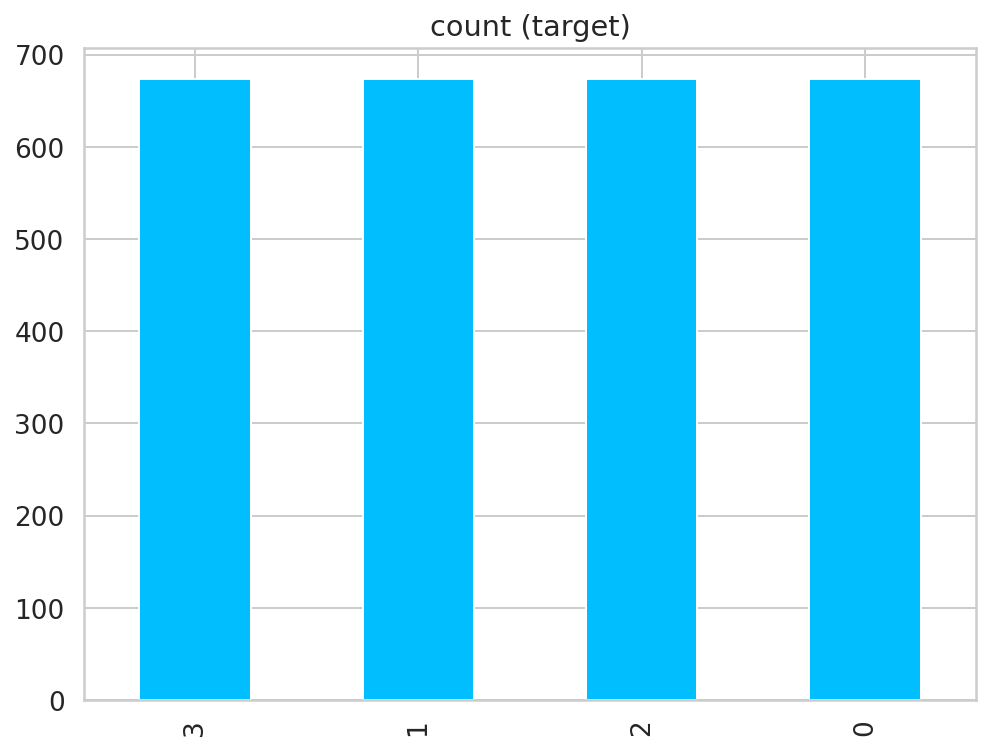

In [ ]:
# Oversampling
class_1_over = class_1.sample(class_count_0, replace=True)
class_2_over = class_2.sample(class_count_0, replace=True)
class_3_over = class_3.sample(class_count_0, replace=True)
test_over = pd.concat([class_1_over, class_2_over, class_3_over,class_0], axis=0)

test_over['Label'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
# import library
import imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x = df['Text'].to_numpy()
x = x.reshape(-1, 1)
y = df['Label'].to_numpy()
# fit predictor and target variable
x_ros, y_ros = ros.fit_resample(x, y)

print('Original dataset shape', Counter(df['Label']))
print('Resample dataset shape', Counter(y_ros))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape Counter({0: 674, 1: 330, 2: 196, 3: 48})
Resample dataset shape Counter({0: 674, 1: 674, 3: 674, 2: 674})


In [ ]:
x_ros

array([['this actually break heart... an elderly kisaan risk life protest protect livelihood heritage land family trade mark future everything trade mark ever known. doesn trade markt look like terrorist me. farmersprotest fuckyourdemocracy kisaanektazindabaad'],
       ['i daughter farmer course i trade markm go roar alongside them. it duty help achieve life comfort reason i receive mine. trade mark westandwithfarmers farmersprotest'],
       ['power people strong people power farmer epitome resilience strength fearlessness hope. register copyright copyright . istandwithfarmers farmersprotest farmersbill2020'],
       ...,
       ["our elder sleep road cold weather rights. shame u can't even tweet farmersprotest takebackfarmbills"],
       ['this new india ! memories 1984sikhgenocide police join murderous mob attack innocent sikhs! farmersprotest'],
       ['journalist commit crime. he cover farmersprotest . request authority immediately release journalist prepare massive protest !']]

In [ ]:
y_ros.shape

(2696,)

### **`New Dataset`**

In [ ]:
# Merging
df_merged = pd.DataFrame(x_ros, columns = ['Text'])
label_merged = pd.DataFrame(y_ros, columns = ['Label'])

In [ ]:
df = pd.concat([df_merged, label_merged], axis=1, join='inner')
df

,Text,Label
0,this actually break heart... an elderly kisaan risk life protest protect livelihood heritage land family trade mark future everything trade mark ever known. doesn trade markt look like terrorist me. farmersprotest fuckyourdemocracy kisaanektazindabaad,0
1,i daughter farmer course i trade markm go roar alongside them. it duty help achieve life comfort reason i receive mine. trade mark westandwithfarmers farmersprotest,0
2,power people strong people power farmer epitome resilience strength fearlessness hope. register copyright copyright . istandwithfarmers farmersprotest farmersbill2020,0
3,coming together beginning. keeping together progress. working together success. delhidornahi farmerprotest,0
4,the farmer articulate aware expert anchor see tv channels. to say protest farmer know good typical urban elite. farmersprotest,0
5,protestors show godi media place. pic 1 anti caa protest 2019. pic 2 farmersprotest 2020 .,0
6,honestly people think bill right farmer protest sure dont know one bill pass farmer question let u cant support farmersprotest hailhailfarmers,0
7,the great khali join protest delhi farmersprotest kisaanmajdoorektazindabad,1
8,meet 83 year old bhajan singh ji. been farmer life hail amritsar punjab. farmersprotest farmersdillichalo,1
9,taxi unions give central government two day ultimatum. if farmer demand met private cab taxis auto truck go indefinite strike delhi farmerprotest farmersprotest,1


In [ ]:
# Shuffling Dataset
from sklearn.utils import shuffle
df = shuffle(df)
df.head(20)

,Text,Label
1269,as many 36 british mps lead tanmanjeet singh dhesi write uk's secretary foreign affairs dominic raab ask raise issue ongoing farmers' agitation india indian counterpart. read itcard farmersprotest,1
1849,some people oppose sake opposition pm namamigange farmersprotest farmbill2020,2
2277,dear delhiites when farmers allow enter delhi protest start protest support inside delhi?!?! diljitdosanjh standwithfarmerschallenge farmersprotest farmlaws2020 farmersissue farmersprotestdelhi2020 farmersprotests,3
23,surely year two bollywood guy gonna make movie whole scene...and make money.... but wont speak fuck word laahnti bootha!! paise de poojari saale!!! farmersprotest takebackfarmbills,1
1175,this amresh kumar migrant worker ambala. he walk like run catch train bihar delhi i meet singhuborder. facing obvious difficulty due farmersprotest still say a kisan must get deserves.,0
1992,rent cause activist share doc international opinion shall manufacture street protest misinformation amp ignorance. she delete tweet. here detail document indiaagainstpropaganda indiatogether,2
1255,farmersprotest have step tikri. have record lot reports. will start upload one one. on follow platform,1
2467,narendra modi stop u u . free diesel despite govt sale restrictions. farmersprotest tractorrally,3
806,joint venture partnership the expect merger singhuborder shaheenbagh khalistanis islamists come together. i long say farmerprotest sequel essence shaheenbaghseason 2,2
501,agriculture lifeline farmer backbone indian economy. save farmer protect economy! _ _ register _jopada,0


### **`Encoding and Padding data`**

    

In [ ]:
#These pretrained transformer models require input data in tokenized form, with some special tokens added to the original tokens.

from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
type(tokenizer)

transformers.models.xlnet.tokenization_xlnet.XLNetTokenizer

In [ ]:
input_txt = "India is my country. All Indians are my brothers and sisters"
encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=16, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=False, truncation=True)

In [ ]:
print('input_ids : ',encodings['input_ids'])

input_ids :  tensor([[ 837,   27,   94,  234,    9,  394, 7056,   41,   94, 4194,   21, 8301,
            4,    3]])


In [ ]:
tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])

['▁India',
 '▁is',
 '▁my',
 '▁country',
 '.',
 '▁All',
 '▁Indians',
 '▁are',
 '▁my',
 '▁brothers',
 '▁and',
 '▁sisters',
 '<sep>',
 '<cls>']

In [ ]:

type(encodings['attention_mask'])

torch.Tensor

**Attention allows the model to focus on the relevant parts of the input sequence as needed**

*The attention_mask is an optional argument used when batching sequences together. This argument indicates to the model which tokens should be attended to, and which should not.*

In [ ]:
attention_mask = pad_sequences(encodings['attention_mask'], maxlen=512, dtype=torch.Tensor ,truncating="post",padding="post")

In [ ]:
attention_mask = attention_mask.astype(dtype = 'int64')
attention_mask = torch.tensor(attention_mask) 
attention_mask.flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
encodings['input_ids']

tensor([[ 837,   27,   94,  234,    9,  394, 7056,   41,   94, 4194,   21, 8301,
            4,    3]])

In [ ]:
token_lens = []

for txt in df['Text']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
print(max(token_lens))

83


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


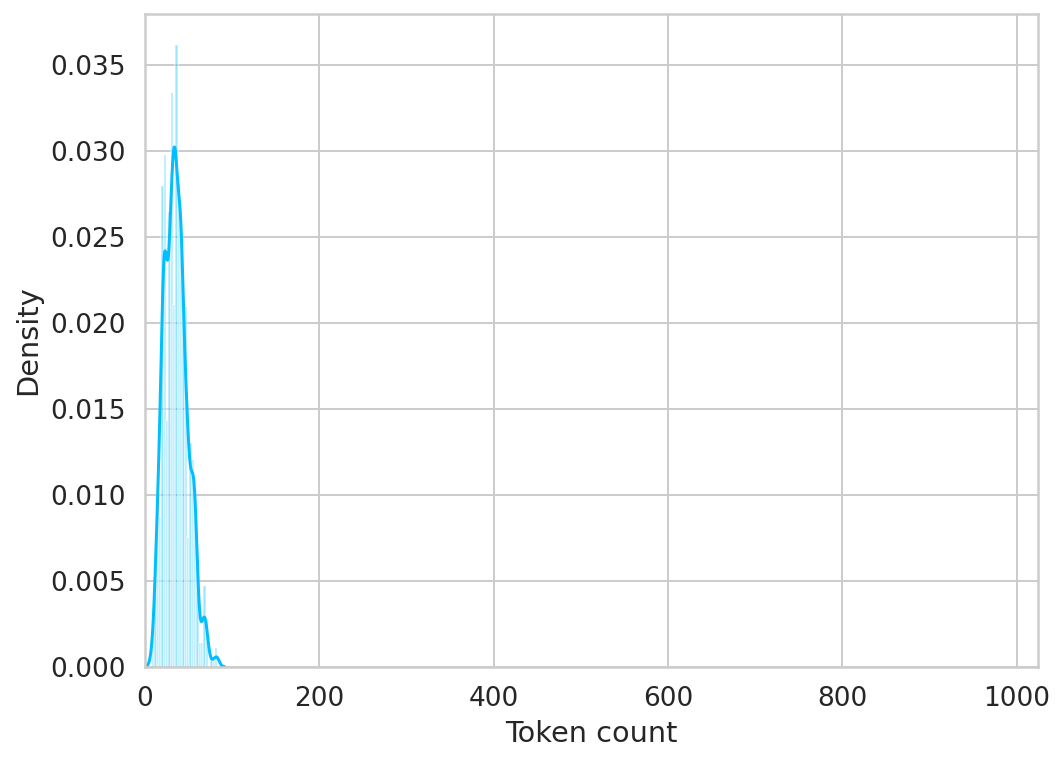

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 1024]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 120

### **`Custom class for enclosing all the above functions of encoding and padding`**

In [ ]:
class Dataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        review = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'review_text': review,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=101)
df_test, df_val = train_test_split(df_test, test_size=0.2, random_state=101)

In [ ]:
df_train.shape, df_test.shape, df_val.shape

((2156, 2), (432, 2), (108, 2))

### **`Creating Custom data loader class`**

In [ ]:

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Dataset(
    tweets = df.Text.to_numpy(),
    targets =df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
# Training, Testing and Validation data loaders

BATCH_SIZE = 2

train_data_loader = create_data_loader(df_train,tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test,tokenizer, MAX_LEN, BATCH_SIZE)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### **`Loading Pretrained XLNet model`**

In [ ]:
# numer of classes = 4
#We will be using the XLNetForSequenceClassification model from Huggingface transformer.


from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 4)
model = model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:

import joblib


#torch.save(model.state_dict(), '/content/drive/MyDrive/IR Labelled Dataset/models/preTrainedXLNet_new.bin')
model.save_pretrained('/content/drive/MyDrive/IR Labelled Dataset/models/preTrainedXLNet_new.bin')

In [ ]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:
# Setting Hyperparameters

EPOCHS = 10

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

### **`Training Phase`**

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.reshape(2,120).shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([2, 120])
torch.Size([2, 120])


In [ ]:
train_data_loader

In [ ]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].reshape(2,120).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

In [ ]:
# Evaluating Model

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(2,120).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **`Fine tuning the model`**

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )


    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)

    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/drive/MyDrive/IR Labelled Dataset/models/prevVersions/xlnet_model .bin')
        best_accuracy = val_acc

   
    

In [ ]:
# Loading the saved model here
path = '/content/drive/MyDrive/IR Labelled Dataset/models/prevVersions/xlnet_model .bin'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
model = model.to(device)

### **`Testing`**

In [ ]:
# Finally, testing on the test set

test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df_test)
)


print('Test Accuracy :', test_acc * 100)
print('Test Loss :', test_loss)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Accuracy : 89.81481481481481
Test Loss : 0.6261179105721466
